# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 8.0 MB/s 
     |████████████████████████████████| 60 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.5 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-17 10:19:07 URL:https://uc6dfb6c6fbd440bef54c634b0d4.dl.dropboxusercontent.com/cd/0/inline2/BnU1tXnX9Xz3ayLDiQfx2Ccr1kOxrb1YL-pDtQh10fIuJbH_inHHCiBdUZ8hTAxwkXCTtfZv4ZddqBCttZ4kuvfAT_K0jY5_Y5I5UWygGf9rVkIbeDiD0w8U87mMZy-TZ2W-2PuGZGmdBOtv5k_52xlUzxEflsbl7PWIoCltVQvN0VKIYTw-jfFEFIpX4COVKO7X10ty1i4zm8gdrELlq2-YeBwCaGKhwqwqP0ao75Q0B8Kdkk86pSFRtf8Pkx04Ad6yr5YfBS4Ki1Pe5C1Ha-1eF173WlNh-rEbNr2YrrHkl2cDuU3uHhHbyzVg97qRaQFUcFw8TDNeULhf6Pwe2wZWYYXFBavbvfDv4r51sMu_0BwErye9NhAjhcKCOWk75pXC1okNser3P47zpH9zOeiurFKYIhFf4VmSmv4xCVCXsw/file [138777773/138777773] -> "train.zip" [1]
2022-06-17 10:19:09 URL:https://uc983173412a9532c81fc19ec7b3.dl.dropboxusercontent.com/cd/0/inline2/BnWOqkoLCv7J0npH6hv8B-y7gDHTSn7MCfnft-sg2E2MCTP9ynbQJ1FBiA8W04-7vsmk5JLjNJ5EgqQ3KFQ_gPzCFFh2DfNcqC_dcNvur1gn-_ezlpOR2Q0HnaFtNEV_JcPSnT9EBs40ReFPMbiev6e0CM-pr-lmA8weJf9F2aUZuFb1Cd5O-BoX4zR-_nKog7eqGfa4nLG_wl5CF2nzpcDzWGcbpCUaQygDDkRygvdgiQzVK-6lg8nP18t_IUB9pfDfEqGXdlzNIBDB9ydw-iIPDN7yjvrAlDH1TUS4bYmzD0IOKCDEBp-rHawyhAyeS0y

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [4]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [5]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [6]:
path = Path('dataset/')

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [9]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [10]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [11]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [13]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [14]:
len(Path('dataset/train/normal').ls()) #401

401

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [15]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [16]:
dls = db.dataloaders(path,bs=128)

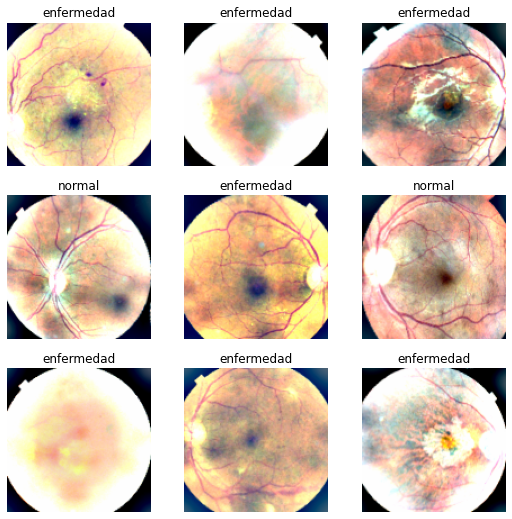

In [17]:
dls.show_batch()

In [18]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [19]:
learn = cnn_learner(dls,resnet18,metrics=accuracy, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.010000000149011612, steep=1.0964781722577754e-06, valley=0.0014454397605732083, slide=0.0063095735386013985)

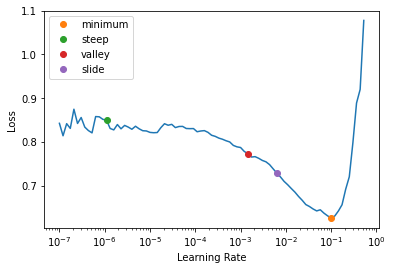

In [20]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,0.755404,0.452486,0.682813,00:09


Better model found at epoch 0 with valid_loss value: 0.4524856209754944.


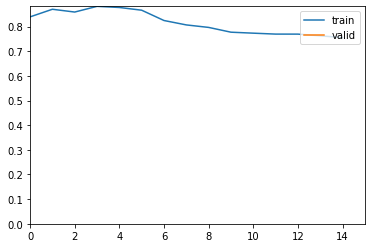

epoch,train_loss,valid_loss,accuracy,time
0,0.530025,0.437094,0.660937,00:09
1,0.491602,0.289831,0.776563,00:08
2,0.450951,0.242051,0.820312,00:08
3,0.434218,0.198834,0.843750,00:08
4,0.397961,0.201645,0.846875,00:09
5,0.370611,0.184848,0.854688,00:09
6,0.332423,0.178649,0.871875,00:08
7,0.309946,0.194762,0.865625,00:10
8,0.280265,0.242914,0.846875,00:09
9,0.260769,0.205991,0.829687,00:08


Better model found at epoch 0 with valid_loss value: 0.4370943605899811.


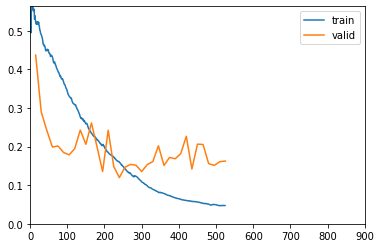

Better model found at epoch 1 with valid_loss value: 0.2898312211036682.
Better model found at epoch 2 with valid_loss value: 0.242051362991333.
Better model found at epoch 3 with valid_loss value: 0.1988336592912674.
Better model found at epoch 5 with valid_loss value: 0.1848476082086563.
Better model found at epoch 6 with valid_loss value: 0.1786489486694336.
Better model found at epoch 12 with valid_loss value: 0.1354944407939911.
Better model found at epoch 15 with valid_loss value: 0.11977791786193848.
No improvement since epoch 15: early stopping


In [21]:
learn.fine_tune(60,base_lr=2e-3)

Exportamos el modelo

In [37]:
learn.to_fp32()
learn.export('modeloBinario_resnet18.pkl')

## Evaluando el modelo

In [38]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [39]:
learn.dls = dlsTest

El valor de la función de perdida (focal loss) es de 0.11 y su accuracy es del 81%.

In [40]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.815625011920929.


(#2) [0.11536940187215805,0.815625011920929]

## Interpretación del modelo

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


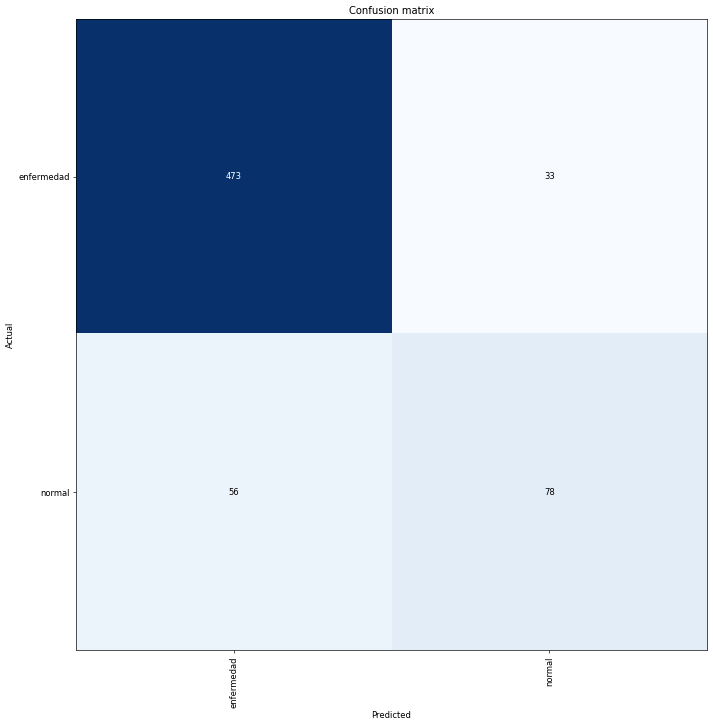

In [66]:
learn_inf = load_learner('modeloBinario_resnet18.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)